In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from torchsummary import summary
#empty gpu cache
torch.cuda.empty_cache()

In [14]:
!pip install TorchCRF

In [2]:
!pip install datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=1e824a5f1c89a742e45407e435f04f7a782f313b3b4d7853675c1d881db75000
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency 

In [2]:
# Load CoNLL dataset from Hugging Face
dataset = load_dataset('conll2003', trust_remote_code=True)

# Build vocabulary for tokens and labels
token2idx = {'<PAD>': 0, '<UNK>': 1}  # Special tokens for padding and unknown words
unique_labels = set(label for example in dataset['train']['ner_tags'] for label in example)
label2idx = {label: i for i, label in enumerate(sorted(unique_labels))}
idx2label = {i: label for label, i in label2idx.items()}

# Populate token2idx with tokens from the dataset
all_tokens = set(token for example in dataset['train']['tokens'] for token in example)
token2idx.update({token: i + 2 for i, token in enumerate(sorted(all_tokens))})  # Offset by 2 for special tokens

# Model configuration
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = len(unique_labels)
PAD_IDX = token2idx['<PAD>']
BATCH_SIZE = 64
EPOCHS = 10

# Custom Dataset class
class NERDataset(Dataset):
    def __init__(self, data, token2idx, label2idx):
        # Debug: Print first token list and its conversion
        print("\nOriginal Sentence (Example 0):", data['tokens'][0])
        print("Original Labels (Example 0):", data['ner_tags'][0])

        self.inputs = [[token2idx.get(token, token2idx['<UNK>']) for token in tokens] for tokens in data['tokens']]
        self.labels = [[label2idx[label] for label in labels] for labels in data['ner_tags']]

        # Debug: Print transformed data
        print("\nTransformed Tokens to Indices (Example 0):", self.inputs[0])
        print("Transformed Labels to Indices (Example 0):", self.labels[0])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pad sequences for batch training
def collate_fn(batch):
    tokens, labels = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=PAD_IDX)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Ignore index for loss calculation
    return tokens_padded.to(device), labels_padded.to(device)
# Prepare data loaders
train_dataset = NERDataset(dataset['train'], token2idx, label2idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
vocab_size = len(token2idx)

# Print dataset and vocab size
print("\nVocabulary Size:", len(token2idx))
print("Number of Examples in Train Dataset:", len(train_dataset))

# Inspect an example from the DataLoader
example_idx = 0  # Index of the example to inspect
tokens_tensor, labels_tensor = train_dataset[example_idx]

# Convert back to original tokens and labels for verification
original_tokens = [list(token2idx.keys())[list(token2idx.values()).index(i)] for i in tokens_tensor.tolist()]
original_labels = [idx2label[i] for i in labels_tensor.tolist()]

print("\nReconstructed Tokens (Example 0):", original_tokens)
print("Reconstructed Labels (Example 0):", original_labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Original Sentence (Example 0): ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Original Labels (Example 0): [3, 0, 7, 0, 0, 0, 7, 0, 0]

Transformed Tokens to Indices (Example 0): [6420, 20821, 7229, 14822, 22700, 14673, 5084, 18390, 125]
Transformed Labels to Indices (Example 0): [3, 0, 7, 0, 0, 0, 7, 0, 0]

Vocabulary Size: 23625
Number of Examples in Train Dataset: 14041

Reconstructed Tokens (Example 0): ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Reconstructed Labels (Example 0): [3, 0, 7, 0, 0, 0, 7, 0, 0]


In [3]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out)
        return logits

In [4]:
# Instantiate model
model = BiLSTM_NER(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding labels in loss calculation


Epoch 1, Loss: 0.3180, Accuracy: 0.9136, Precision: 0.7680, Recall: 0.5771, F1-Score: 0.6535
Epoch 2, Loss: 0.0672, Accuracy: 0.9806, Precision: 0.9217, Recall: 0.8958, F1-Score: 0.9084
Epoch 3, Loss: 0.0224, Accuracy: 0.9935, Precision: 0.9691, Recall: 0.9620, F1-Score: 0.9655
Epoch 4, Loss: 0.0097, Accuracy: 0.9972, Precision: 0.9856, Recall: 0.9841, F1-Score: 0.9849
Epoch 5, Loss: 0.0051, Accuracy: 0.9985, Precision: 0.9923, Recall: 0.9919, F1-Score: 0.9921
Epoch 6, Loss: 0.0025, Accuracy: 0.9994, Precision: 0.9968, Recall: 0.9967, F1-Score: 0.9968
Epoch 7, Loss: 0.0013, Accuracy: 0.9997, Precision: 0.9981, Recall: 0.9977, F1-Score: 0.9979
Epoch 8, Loss: 0.0008, Accuracy: 0.9998, Precision: 0.9984, Recall: 0.9988, F1-Score: 0.9986
Epoch 9, Loss: 0.0007, Accuracy: 0.9998, Precision: 0.9989, Recall: 0.9989, F1-Score: 0.9989
Epoch 10, Loss: 0.0017, Accuracy: 0.9996, Precision: 0.9979, Recall: 0.9979, F1-Score: 0.9979


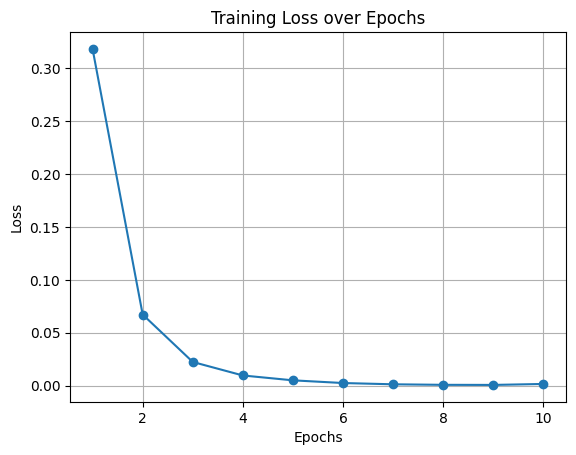

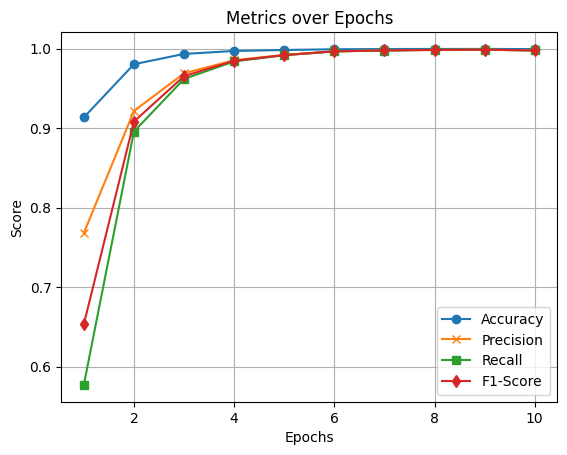

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Initialize lists to store losses and metrics
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

def train_model():
    model.train()
    for epoch in range(EPOCHS):  # Number of epochs
        epoch_loss = 0
        all_preds = []
        all_labels = []

        for tokens, labels in train_loader:

            optimizer.zero_grad()
            outputs = model(tokens)  # outputs shape: (batch_size, seq_len, NUM_CLASSES)
            loss = criterion(outputs.view(-1, NUM_CLASSES), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Get predictions
            preds = outputs.argmax(dim=-1)  # shape: (batch_size, seq_len)

            # Move tensors to CPU and flatten
            preds_flat = preds.view(-1).cpu().numpy()
            labels_flat = labels.view(-1).cpu().numpy()

            # Exclude PAD_LABEL
            mask = labels_flat != -100
            masked_preds = preds_flat[mask]
            masked_labels = labels_flat[mask]

            # Collect the predictions and labels
            all_preds.extend(masked_preds)
            all_labels.extend(masked_labels)

        # Convert lists to numpy arrays
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Compute metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        # Store metrics
        loss_values.append(epoch_loss / len(train_loader))
        accuracy_values.append(acc)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Plot loss graph
    plt.figure()
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.show()

    # Plot accuracy graph
    plt.figure()
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run training
train_model()

In [6]:
torch.cuda.empty_cache()

from TorchCRF import CRF
import torch.optim as optim
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)
        self.crf = CRF(num_classes, batch_first=True)

    def forward(self, sentences, labels=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if labels is not None:
            # Determine valid positions for the CRF loss based on padding
            mask = labels != -100
            # Instead of the full mask calculation during scoring, this mask ensures correct label indices.
            valid_labels = torch.where(labels >= 0, labels, torch.zeros_like(labels))

            crf_loss = -self.crf(emissions, valid_labels, mask=mask)
            return crf_loss
        else:
            # For decoding, use mask based on sentence padding
            mask = sentences != PAD_IDX
            return self.crf.decode(emissions, mask=mask)

# Instantiate the model
model = BiLSTM_CRF(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

TypeError: CRF.__init__() got an unexpected keyword argument 'batch_first'

In [21]:
!pip install torchcrf


  Using cached TorchCRF-1.1.0-py3-none-any.whl.metadata (2.3 kB)
Using cached TorchCRF-1.1.0-py3-none-any.whl (5.2 kB)


In [17]:
def train_model():
    model.train()
    for epoch in range(EPOCHS):  # Number of epochs
        epoch_loss = 0
        all_preds, all_labels = [], []

        for tokens, labels in train_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()

            try:
                loss = model(tokens, labels=labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            except Exception as e:
                print(f"Exception: {e}")
                print(f"Tokens: {tokens.shape}, Labels: {labels.shape}")
                print(f"Sample Tokens: {tokens[0]}, Sample Labels: {labels[0]}")
                return

            # Get predictions using CRF decode
            preds = model(tokens)  # Decoded predictions

            # Collect predictions and true labels for evaluation
            for i in range(len(preds)):
                seq_len = (labels[i] != -100).sum().item()
                all_preds.extend(preds[i][:seq_len])  # Only valid token predictions
                all_labels.extend(labels[i][:seq_len].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        # Store metrics for plotting
        loss_values.append(epoch_loss / len(train_loader))
        accuracy_values.append(acc)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Plot loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot accuracy and metrics graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

try:
    train_model()
except Exception as e:
    print(e)

Exception: grad can be implicitly created only for scalar outputs
Tokens: torch.Size([64, 52]), Labels: torch.Size([64, 52])
Sample Tokens: tensor([ 5171, 22570, 16670, 15401, 19479, 12739, 22700, 14471,     3, 21223,
            3, 14234, 18482, 13889, 22431,  4911, 17255, 22570, 21354, 16226,
        22700, 22570, 20185, 18470, 22698, 18072, 22619, 14043, 13692, 17524,
        23596,   125,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0'), Sample Labels: tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100], device='cuda:0')


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [8]:
# Load the CoNLL 2003 dataset
dataset = load_dataset('conll2003')

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

# Define a function to tokenize the input examples
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding='max_length', max_length=128)
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize and align labels
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [14]:
class NERDataset(Dataset):
    def __init__(self, dataset):
        self.encodings = {
            'input_ids': dataset['input_ids'],
            'attention_mask': dataset['attention_mask'],
            'labels': dataset['labels']
        }

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Prepare DataLoader
train_dataset = NERDataset(tokenized_datasets['train'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [15]:
print(tokenized_datasets['train'])

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 14041
})


In [16]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(dataset['train'].features['ner_tags'].feature.names))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 220/220 [04:18<00:00,  1.18s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 0.2222, Accuracy: 0.8858, Precision: 0.7395, Recall: 0.6505, F1-Score: 0.6865


100%|██████████| 220/220 [04:17<00:00,  1.17s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 0.0510, Accuracy: 0.9348, Precision: 0.8477, Recall: 0.8439, F1-Score: 0.8456


100%|██████████| 220/220 [04:18<00:00,  1.17s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Loss: 0.0289, Accuracy: 0.9409, Precision: 0.8683, Recall: 0.8718, F1-Score: 0.8699


100%|██████████| 220/220 [04:17<00:00,  1.17s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 0.0185, Accuracy: 0.9437, Precision: 0.8769, Recall: 0.8821, F1-Score: 0.8794


100%|██████████| 220/220 [04:18<00:00,  1.17s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Loss: 0.0150, Accuracy: 0.9447, Precision: 0.8671, Recall: 0.8864, F1-Score: 0.8765


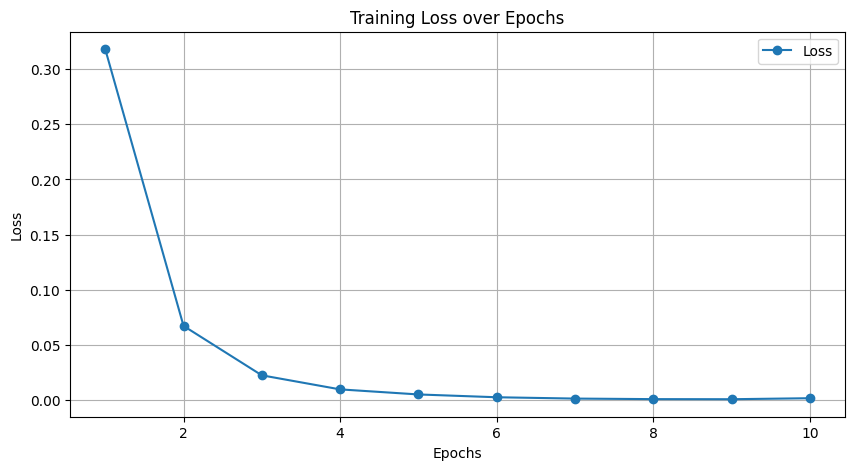

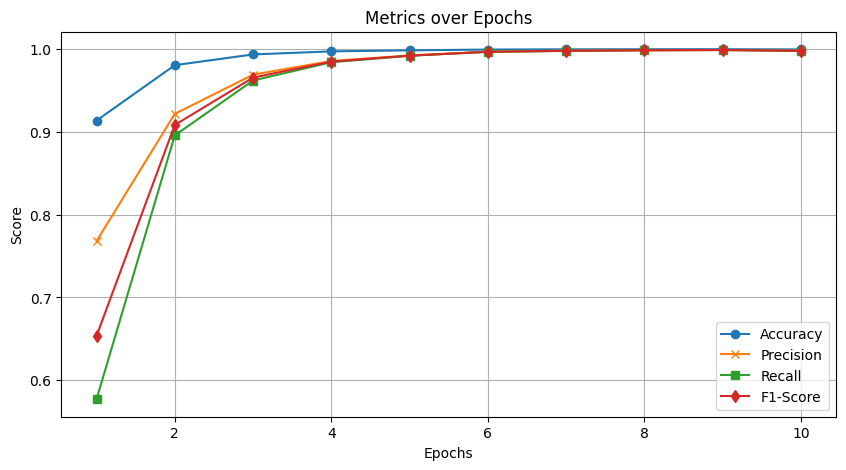

In [17]:
optimizer = AdamW(model.parameters(), lr=5e-5)
import tqdm

def train_model():
    model.train()
    for epoch in range(5):  # Number of epochs
        epoch_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm.tqdm(train_loader):
            inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            # print(f"Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Convert logits to predictions
            preds = torch.argmax(logits, dim=-1)

            # Collect predictions and true labels for evaluation, ignoring padded values
            for i in range(len(preds)):
                seq_len = (labels[i] != -100).sum().item()
                all_preds.extend(preds[i, :seq_len].cpu().numpy())
                all_labels.extend(labels[i, :seq_len].cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        # Plot loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot accuracy and metrics graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

try:
    train_model()
except Exception as e:
    print(e)